In [1]:
import math
import pickle
import random
from collections import namedtuple, deque
from itertools import count

import torch
import cv2
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def print_n_params(model):
    n_params = sum(p.numel() for p in model.parameters())
    print(n_params)

def image_preprocessing(img):
    '''
    Convert 96, 96, 3 image to 84, 84
    '''
    img = cv2.resize(img, dsize=(84, 84))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

def plot_statistics(x, y, title, x_axis, y_axis):
    plt.plot(x, y)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.grid(True)
    plt.savefig(f'{title.replace(" ", "_")}.png')
    plt.show()

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class CarEnvironment(gym.Wrapper):
    def __init__(self, env, skip_frames=2, stack_frames=4, no_operation=5, **kwargs):
        super().__init__(env, **kwargs)
        self._no_operation = no_operation
        self._skip_frames = skip_frames
        self._stack_frames = stack_frames

    def reset(self):
        observation, info = self.env.reset()
        for _ in range(self._no_operation):
            observation, _, _, _, info = self.env.step(0) # 0 for no-op
        observation = image_preprocessing(observation)
        self.stack_state = np.tile(observation, (self._stack_frames, 1, 1)) # 4, 84, 84
        return self.stack_state, info

    def step(self, action):
        total_reward = 0
        for _ in range(self._skip_frames):
            observation, reward, terminated, truncated, info = self.env.step(action)
            total_reward += reward
            if terminated or truncated:
                break
        observation = image_preprocessing(observation)
        self.stack_state = np.concatenate((self.stack_state[1:], observation[np.newaxis]), axis=0)
        return self.stack_state, total_reward, terminated, truncated, info

class ViT(nn.Module):
    def __init__(self, image_size=84, patch_size=84, n_channels=4, embed_dim=32, action_space=5, n_layers=2, n_heads=16):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        self.n_patches = (image_size // patch_size) ** 2
        self.patch_dim = n_channels * patch_size * patch_size
        self.patch_size = patch_size
        self.patch_embedding = nn.Linear(self.patch_dim, embed_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, self.n_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.encoder_layer = nn.TransformerEncoderLayer(embed_dim, n_heads, 4 * embed_dim, dropout=0, batch_first=True, norm_first=True, bias=False)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, n_layers, enable_nested_tensor=False)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim, bias=False),
            nn.Linear(embed_dim, action_space)
        )

    def image2patch(self, image):
        batch, channel, height, width = image.shape

        #image: batch, channel, height // patch_size, width // patch_size, patch_size, patch_size
        image = image.reshape(batch, channel, height // self.patch_size, width // self.patch_size, self.patch_size, self.patch_size)

        #image: batch, height // patch_size, width // patch_size, patch_size, patch_size, channel
        image = image.permute(0, 2, 3, 4, 5, 1)

        #image: batch, height // patch_size * width // patch_size, patch_size * patch_size * channel
        image = image.reshape(batch, height // self.patch_size * width // self.patch_size, self.patch_size * self.patch_size * channel)

        return image
    
    def forward(self, image):
        patch = self.image2patch(image)
        patch = self.patch_embedding(patch)
        batch_size, n_seq, embed_dim = patch.shape
        cls_tokens = self.cls_token.repeat((batch_size, 1, 1))
        patch = torch.cat((cls_tokens, patch), dim=1)
        patch += self.pos_embedding[:, : n_seq + 1]
        patch = self.encoder(patch)
        patch = patch[:, 0]
        patch = self.mlp_head(patch)
        return patch

# 677_429 params
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._n_features = 32 * 9 * 9
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(self._n_features, 256),
            nn.ReLU(),
            nn.Linear(256, out_channels),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view((-1, self._n_features))
        x = self.fc(x)
        return x

# Actual ViT parameter settings
class DQN:
    def __init__(self, action_space, batch_size=256, gamma=0.99, eps_start=0.9, eps_end=0.05, eps_decay=1000, lr=0.0001, use_vit=True):
        self._n_observation = 4
        self._n_actions = 5
        self._action_space = action_space
        self._batch_size = batch_size
        self._gamma = gamma
        self._eps_start = eps_start
        self._eps_end = eps_end
        self._eps_decay = eps_decay
        self._lr = lr
        self._total_steps = 0
        self._evaluate_loss = []
        if use_vit:
            self.network = ViT(patch_size=21, embed_dim=256, n_layers=4, n_heads=16).to(device)
            self.target_network = ViT(patch_size=21, embed_dim=256, n_layers=4, n_heads=16).to(device)
            self.target_network.load_state_dict(self.network.state_dict())
        else:
            self.network = CNN(self._n_observation, self._n_actions).to(device)
            self.target_network = CNN(self._n_observation, self._n_actions).to(device)
            self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = optim.AdamW(self.network.parameters(), lr=self._lr, amsgrad=True)
        self._memory = ReplayMemory(10000)

    def select_action(self, state, evaluation_phase=False):
        sample = random.random()
        eps_threshold = self._eps_end + (self._eps_start - self._eps_end) * math.exp(-1. * self._total_steps / self._eps_decay)
        self._total_steps += 1
        if evaluation_phase:
            with torch.no_grad():
                return self.target_network(state).max(1).indices.view(1, 1)
        elif sample > eps_threshold:
            with torch.no_grad():
                return self.network(state).max(1).indices.view(1, 1)
        else:
            return torch.tensor([[self._action_space.sample()]], device=device, dtype=torch.long)

    def train(self):
        if len(self._memory) < self._batch_size:
            return
        transitions = self._memory.sample(self._batch_size)
        batch = Transition(*zip(*transitions))
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        state_action_values = self.network(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(self._batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1).values
        expected_state_action_values = (next_state_values * self._gamma) + reward_batch
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.network.parameters(), 100)
        self.optimizer.step()
        self._evaluate_loss.append(loss.item())

    def copy_weights(self):
        self.target_network.load_state_dict(self.network.state_dict())

    def get_loss(self):
        return self._evaluate_loss

    def save_model(self, i):
        torch.save(self.target_network.state_dict(), f'model_weights_{i}.pth')

    def load_model(self, i):
        self.target_network.load_state_dict(torch.load(f'model_weights_{i}.pth'))

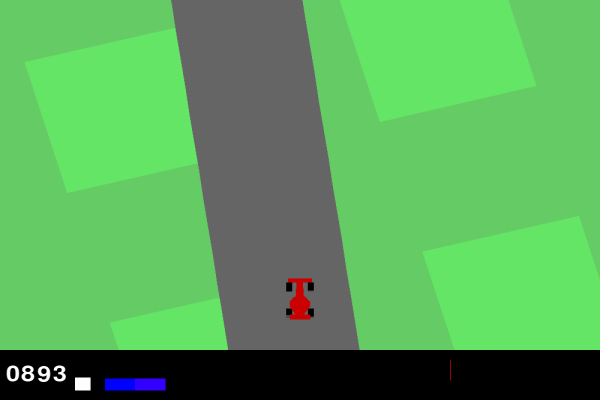

887.8817034700193


OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


In [2]:
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = CarEnvironment(eval_env)
n_actions = eval_env.action_space
agent = DQN(n_actions)
agent.load_model(1000)
frames = []
scores = 0
s, _ = eval_env.reset()
eval_env.np_random = np.random.default_rng(42)
done, ret = False, 0
from PIL import Image as PILImage
def render2img(_img):
    return PILImage.fromarray(_img, "RGB")
handle = display(None, display_id=True)
while not done:
    _render = eval_env.render()
    handle.update(render2img(_render))
    frames.append(_render)
    s = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
    a = agent.select_action(s, evaluation_phase=True)
    discrete_action = a.item() % 5
    s_prime, r, terminated, truncated, info = eval_env.step(discrete_action)
    s = s_prime
    ret += r
    done = terminated or truncated
    if terminated:
      print(terminated)
scores += ret
print(scores)
def animate(imgs, video_name, _return=True):
    import cv2
    import os
    import string
    import random
    if video_name is None:
        video_name = ''.join(random.choice(string.ascii_letters) for i in range(18)) + '.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
animate(frames, None)